In [68]:
import os
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn import manifold
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.io import output_notebook
output_notebook()

%matplotlib nbagg
plt.rcParams["figure.figsize"] = (8,6)

Loading BokehJS ...

In [2]:
def get_path(person, number):
    filepath = os.path.join('s{}'.format(person), '{}.pgm'.format(number))
    return filepath

In [3]:
def load_image(filepath):
    im = Image.open(filepath)
    return im

In [4]:
def show_image(im):
    fig1, ax1 = plt.subplots(1, 1)
    ax1.imshow(im, cmap = 'gray');
    return

<IPython.core.display.Javascript object>


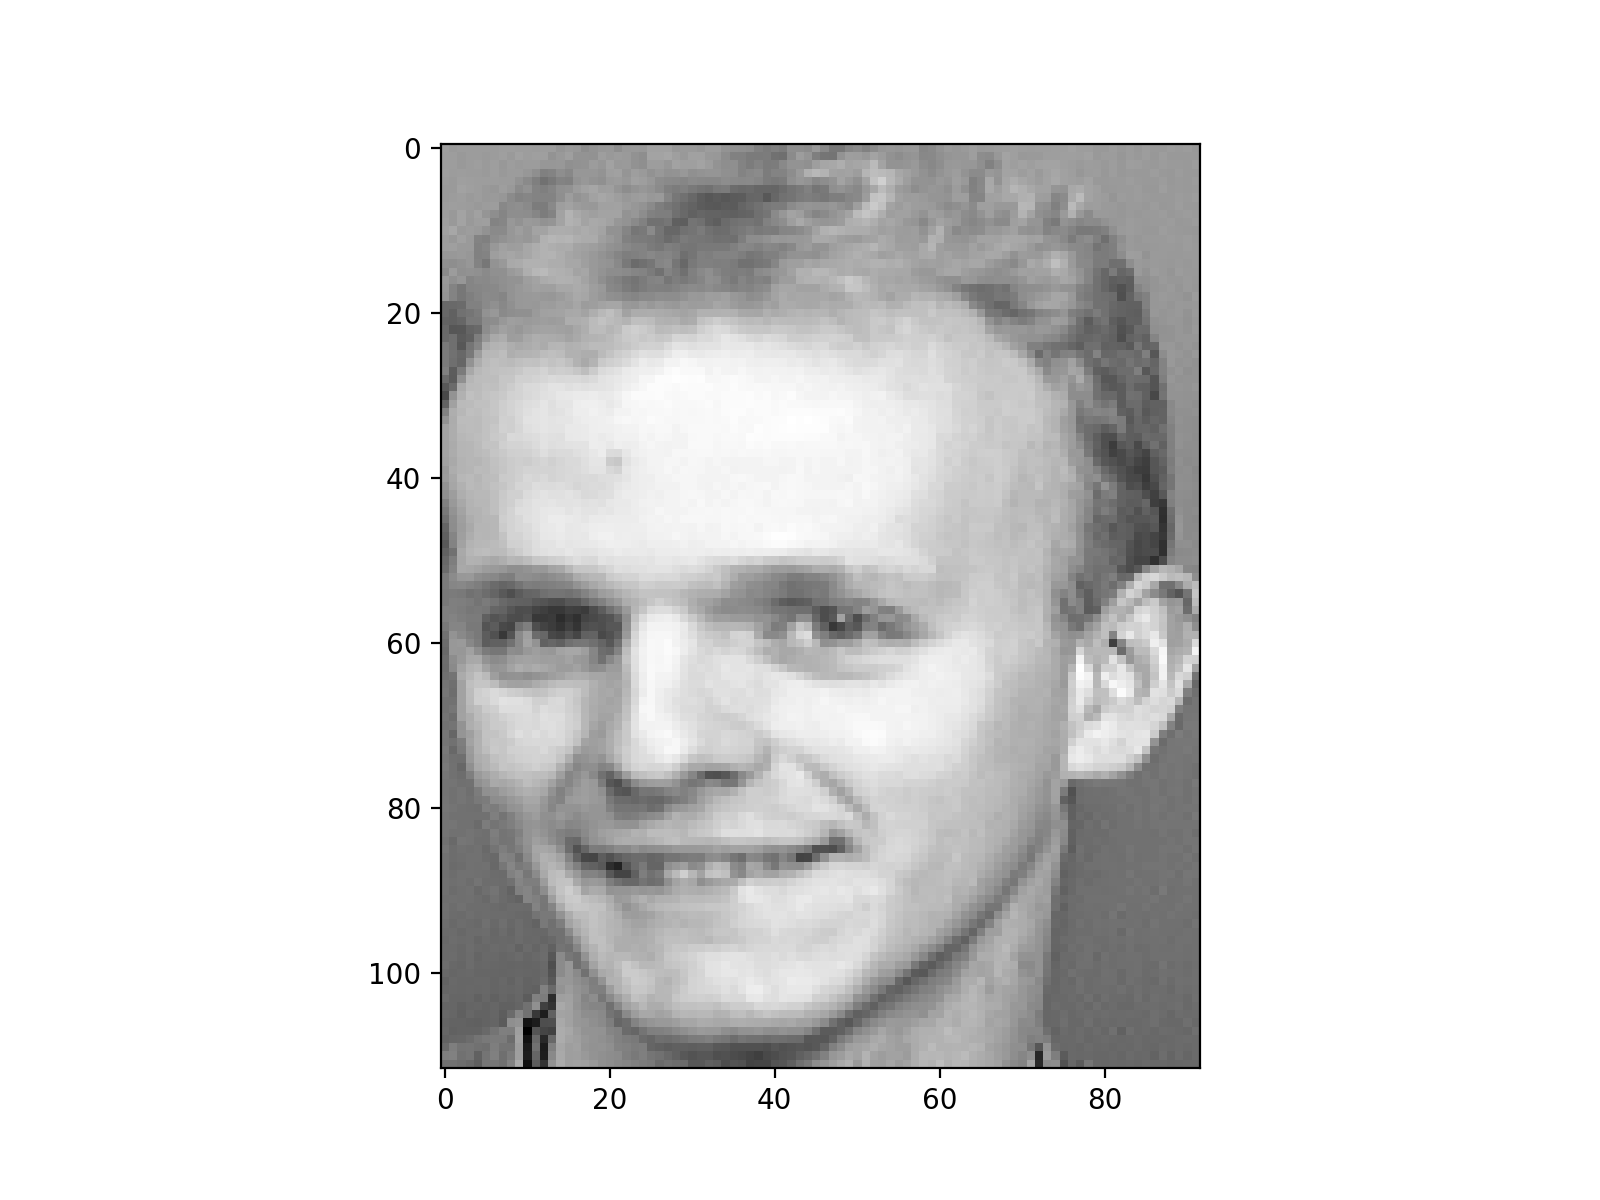

In [51]:
person = 5
number = 5
filepath = get_path(person, number)
im = load_image(filepath)
show_image(np.asarray(im))

In [7]:
people = 41
numbers = 11
ims = np.empty((400,10304))
i = 0
for person in range(1, people):
    for number in range(1, numbers):
        filepath = get_path(person, number)
        im = load_image(filepath)
        im_pro = np.array(im).ravel().astype(float)
        ims[i] = im_pro
        i += 1

In [8]:
iso = manifold.Isomap(n_neighbors=5, n_components=2, max_iter=500)
Z = iso.fit_transform(ims)

In [82]:
#fig = plt.figure(figsize=(10,8))
#ax = fig.add_subplot(111)

#ax.scatter(Z[:, 0], Z[:, 1], c='r', cmap = plt.cm.Spectral);

#for i in range(Z.shape[0]):
#    plt.text(Z[i,0], Z[i,1], str(i))
    
source = ColumnDataSource(
        data=dict(
            x=Z[:, 0],
            y=Z[:, 1],
            desc=list(range(Z.shape[0])),
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover],
           title="Mouse over the dots")

p.circle('x', 'y', size=10, source=source)
show(p)

In [12]:
def init():
    ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2], marker='o', s=20, c="goldenrod", alpha=0.6)
    return fig,

In [13]:
def animate(i):
    ax.view_init(elev=15., azim=i)
    return fig,

In [14]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)
plt.show()

In [15]:
from sklearn.multioutput import MultiOutputRegressor

In [16]:
lin = sklearn.tree.ExtraTreeRegressor(max_depth=19)
#lin = MultiOutputRegressor(svc)
lin.fit(Z, ims)

ExtraTreeRegressor(criterion='mse', max_depth=19, max_features='auto',
          max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, random_state=None,
          splitter='random')

In [17]:
lin.score(Z, ims)

1.0

<IPython.core.display.Javascript object>


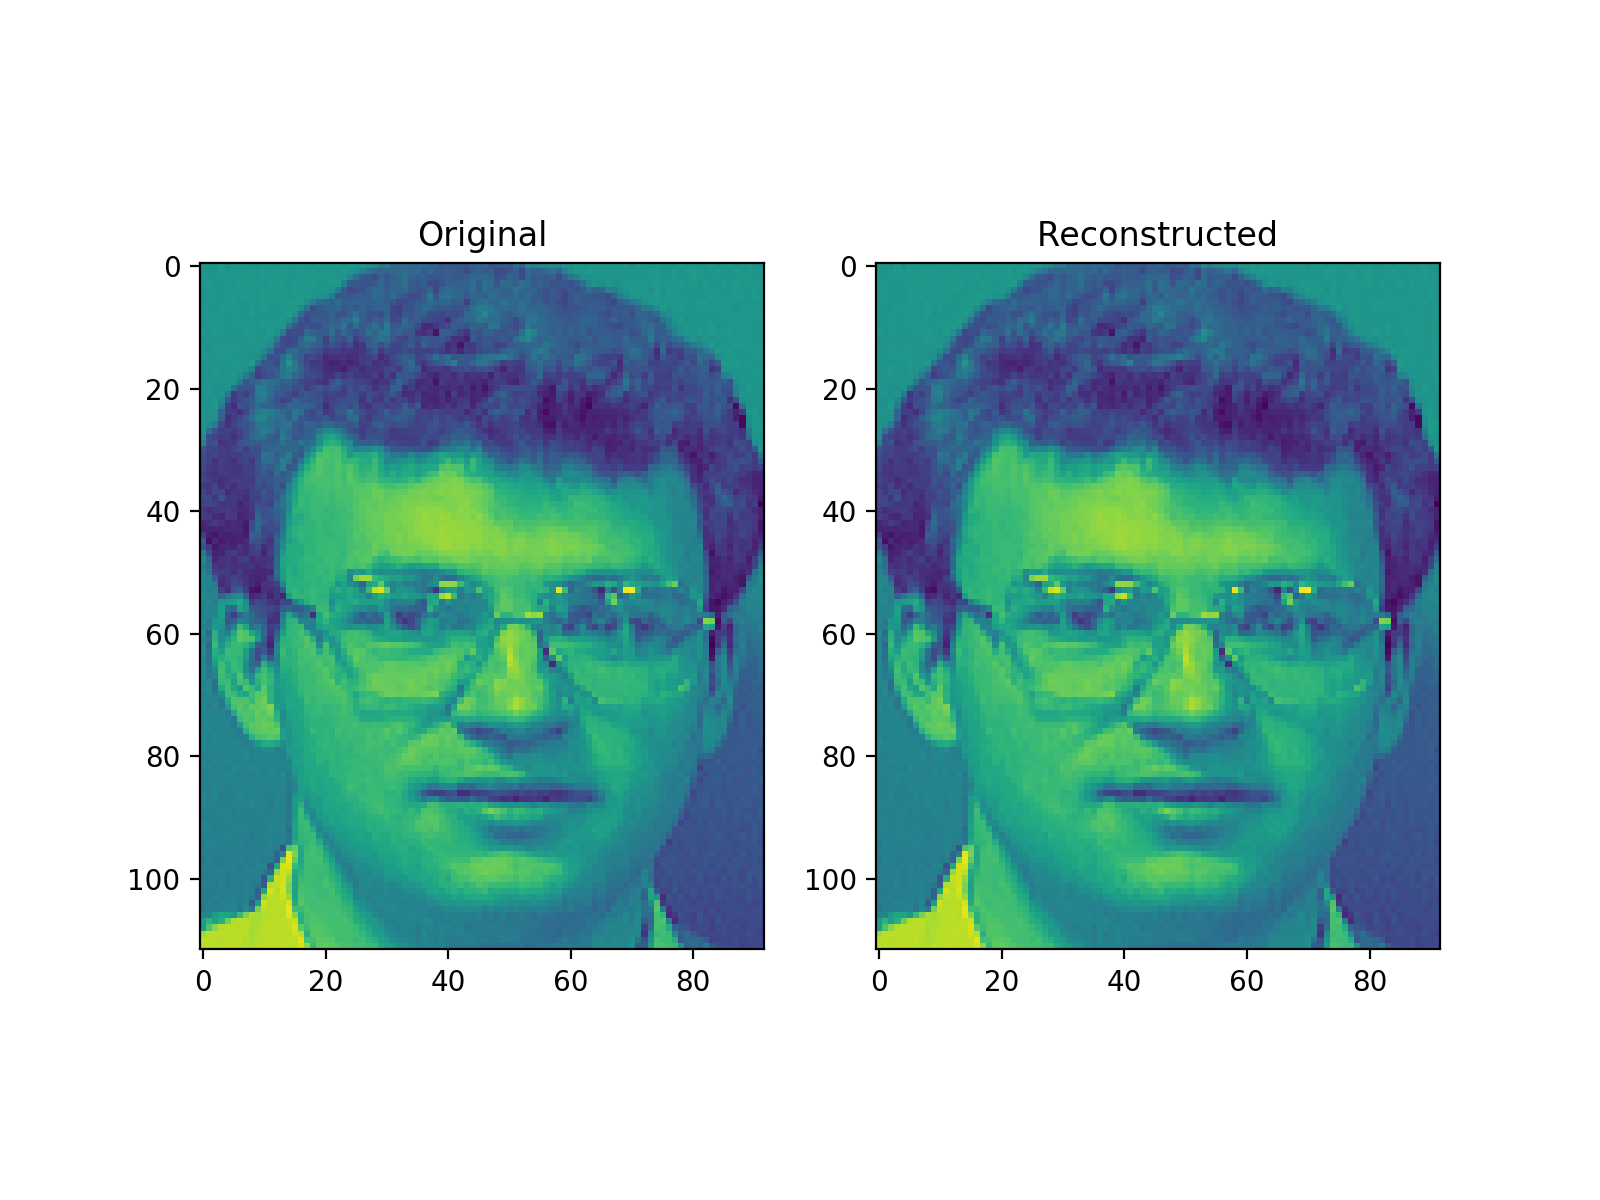

Text(0.5,1,'Reconstructed')

In [18]:
pred = lin.predict(Z[50].reshape(1, -1));
fig_new, [ax1,ax2] = plt.subplots(1,2)
ax1.imshow(ims[50].reshape((112,92)))
ax1.set_title('Original')
ax2.imshow(pred.reshape((112,92)))
ax2.set_title('Reconstructed')

<IPython.core.display.Javascript object>


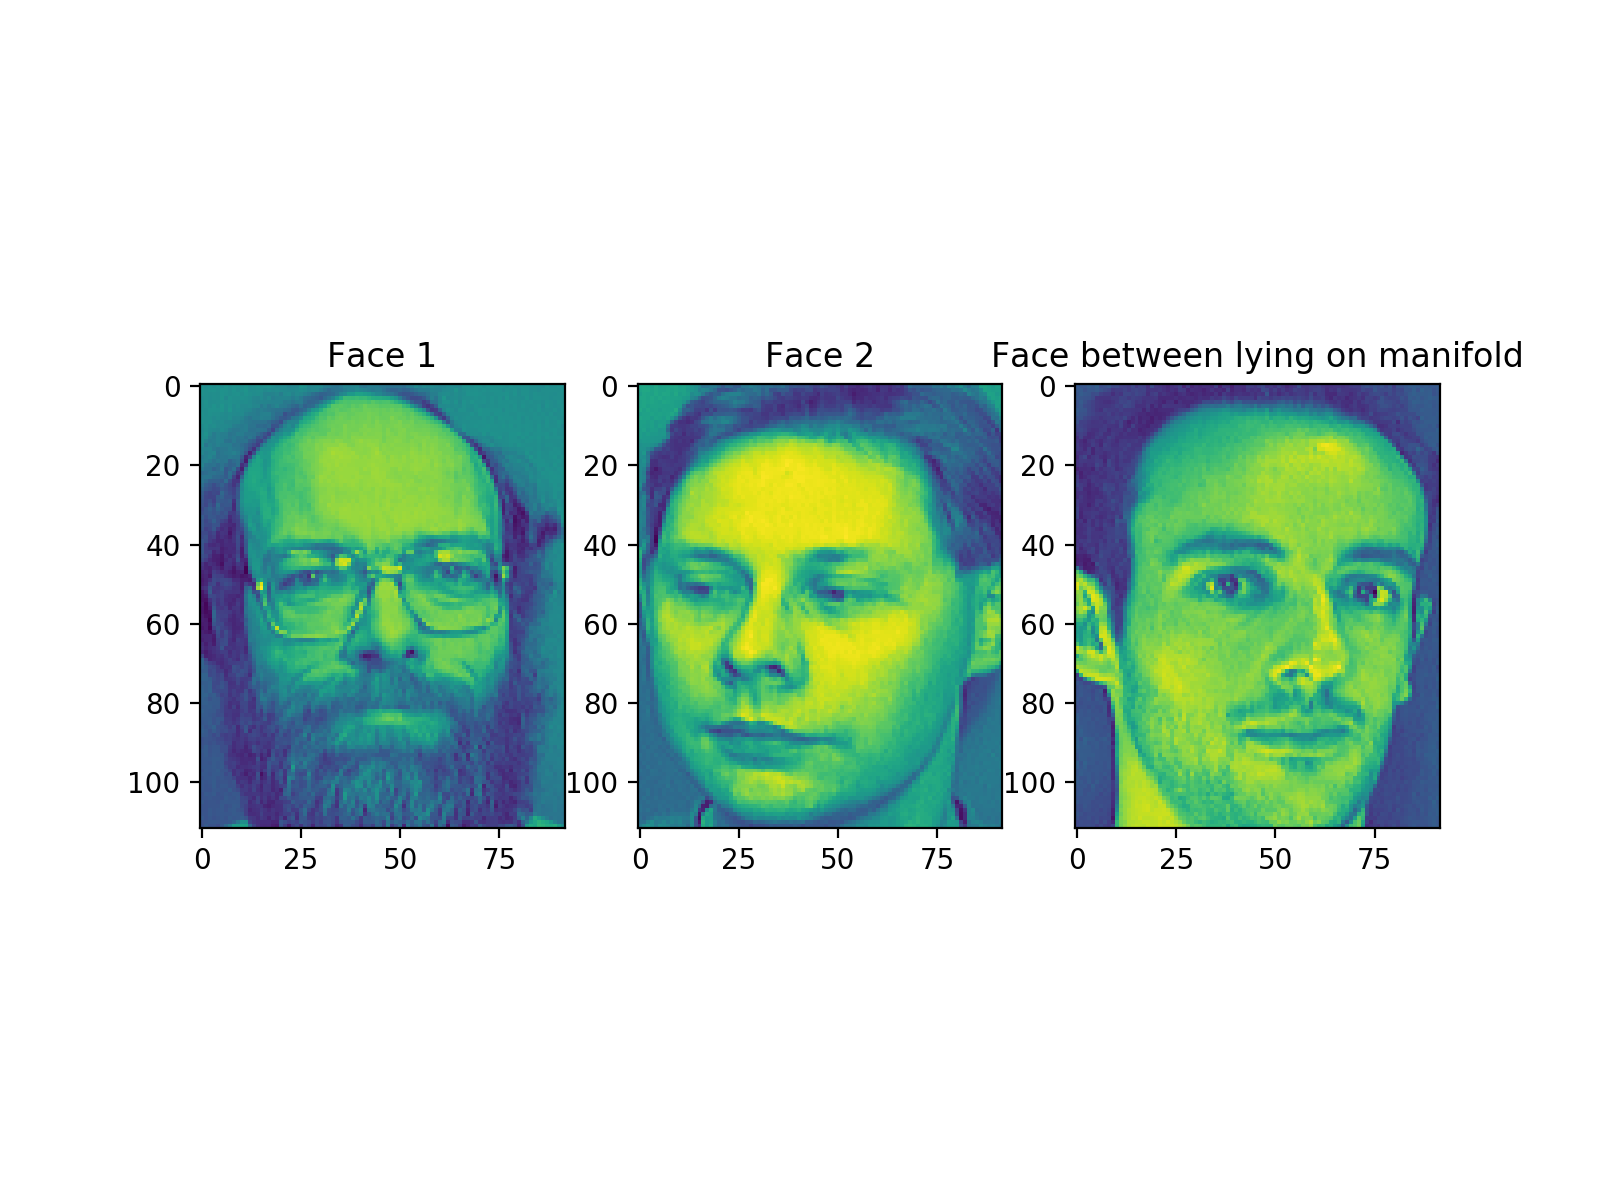

In [24]:
person1 = 360 #10
person2 = 35 #55
test = ((Z[person1] + Z[person2]) / 2) + 50*np.random.randn(*Z[person1].shape)
pred = lin.predict(test.reshape(1, -1))
fig_newer, [ax1, ax2, ax3] = plt.subplots(1, 3)
ax1.imshow(ims[person1].reshape((112,92)))
ax1.set_title('Face 1')
ax2.imshow(ims[person2].reshape((112,92)))
ax2.set_title('Face 2')
ax3.imshow(pred.reshape((112,92)))
ax3.set_title('Face between lying on manifold');

lbd = np.linspace(0, 1, 101)
for i in range(101):
    test = (lbd[i] * Z[person1]) + ((1-lbd[i]) * Z[person2])
    pred = lin.predict(test.reshape(1, -1))
    im = Image.fromarray(pred.reshape((112, 92)))
    im = im.convert('RGB')
    im.save('{}.png'.format(i))

In [ ]:
os.system("ffmpeg -f image2 -r 20 -i ./%01d.png -vcodec mpeg4 -y ./swissGenevaLake.mp4")

In [25]:
import networkx as nx
from scipy import spatial

In [26]:
distances = spatial.distance.squareform(spatial.distance.pdist(Z, 'braycurtis'))

In [27]:
kernel_width = distances.mean()
weights = np.exp(-np.square(distances) / (kernel_width ** 0.1))
for i in range(weights.shape[0]):
    weights[i][i] = 0

In [28]:
NEIGHBORS = 2
#NEIGHBORS = 100
# Your code here.

#Find sorted indices of weights for each row
indices = np.argsort(weights, axis = 1)

#Create a zero matrix which would later be filled with sparse weights
n_weights = np.zeros((weights.shape[0], weights.shape[1]))

#Loop that iterates over the 'K' strongest weights in each row, and assigns them to sparse matrix, leaving others zero
for i in range(indices.shape[0]):
    for j in range(indices.shape[1] - NEIGHBORS, indices.shape[1]):
        col = indices[i][j]
        n_weights[i][col] = weights[i][col]  

#Imposing symmetricity
big = n_weights.T > n_weights
n_weights_s = n_weights - n_weights * big + n_weights.T * big

In [29]:
G = nx.from_numpy_matrix(n_weights_s)

<IPython.core.display.Javascript object>


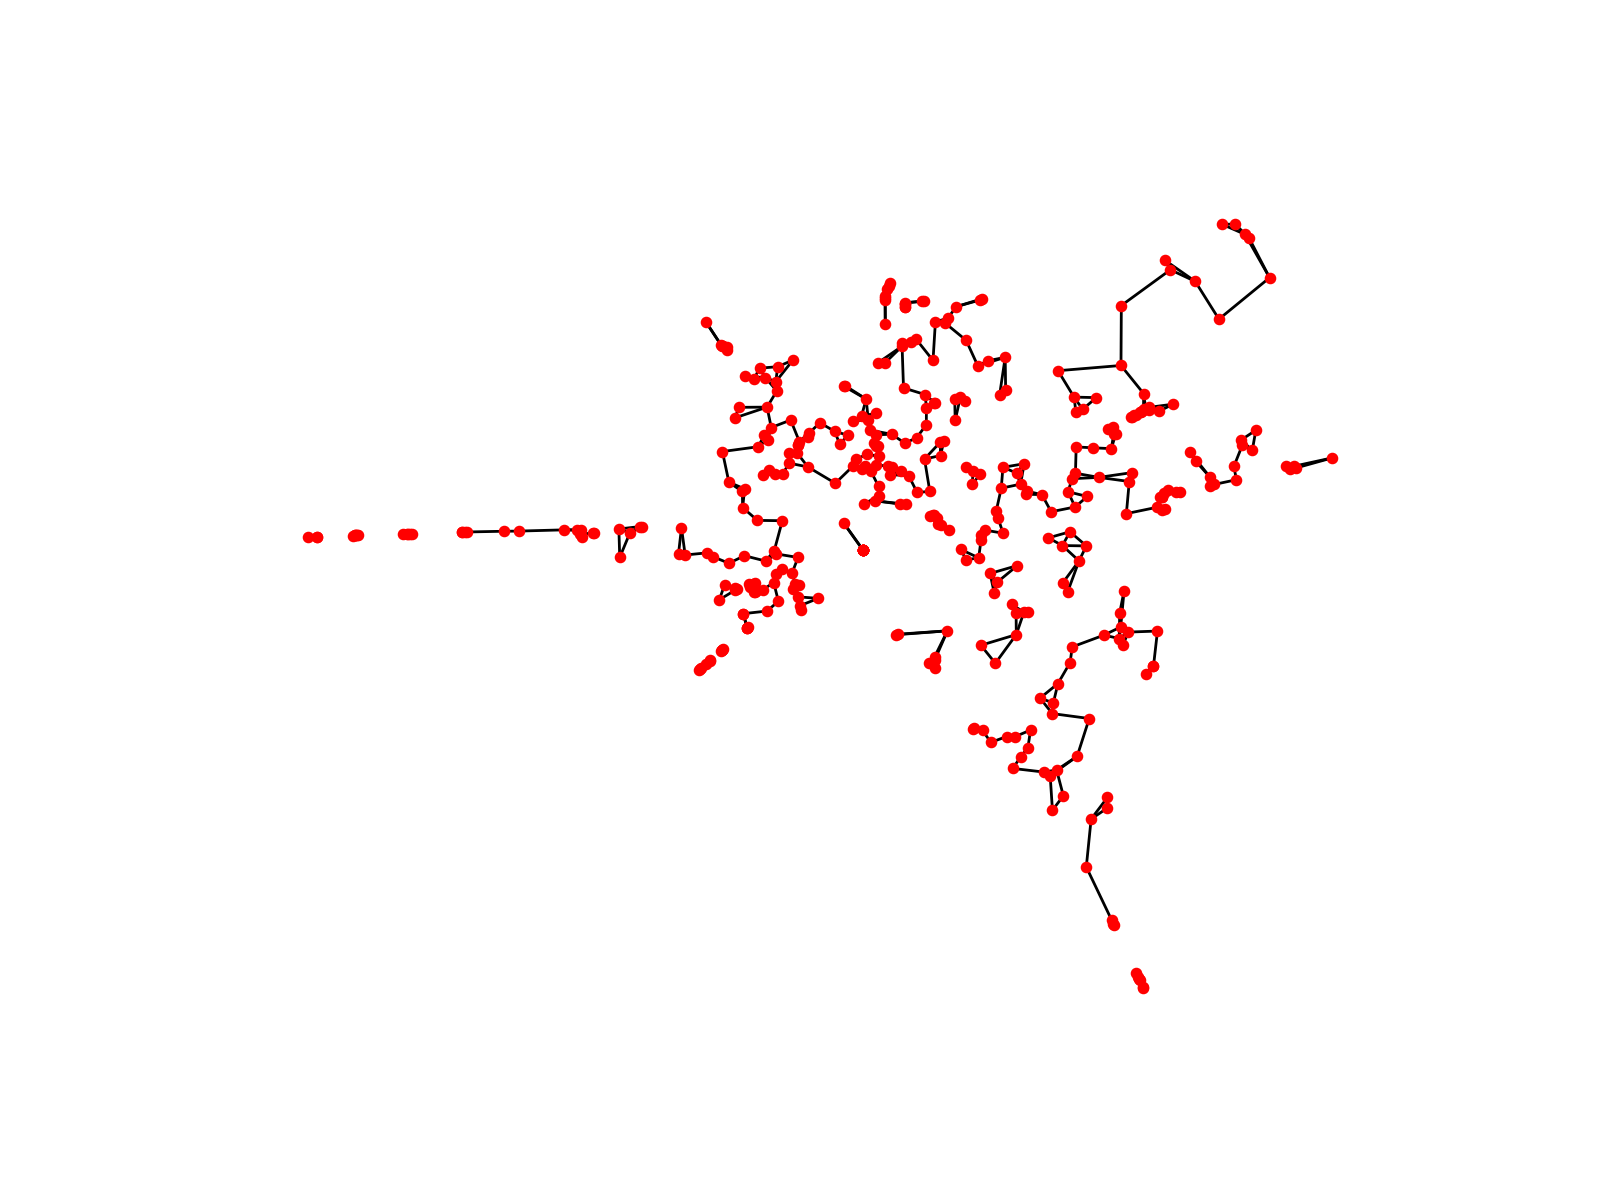

/Users/atul/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/atul/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Users/atul/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/Users/atul/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without f

In [30]:
pos = {}
for i in range(400):
    pos[i] = Z[i]

fig2,ax2 = plt.subplots()
nx.draw(G, pos, ax=ax2, node_size=10)

In [46]:
imlist=nx.all_pairs_dijkstra_path(G)[1][49]

In [47]:
imlist

[1, 5, 113, 45, 44, 47, 397, 48, 115, 174, 172, 392, 175, 391, 177, 49]

In [48]:
N=25
lbd = np.linspace(0, 1, N)
counter = 0
for count, i in enumerate(imlist):
    if count != len(imlist) - 1:
        person1 = i
        person2 = imlist[count + 1]
        for j in range(N):
            test = (lbd[j] * Z[person1]) + ((1 - lbd[j]) * Z[person2])
            pred = lin.predict(test.reshape(1, -1))
            im = (lbd[j] * ims[person2]) + ((1 - lbd[j]) * ims[person1])
            im = Image.fromarray(im.reshape((112, 92)))
            im = im.convert('RGB')
            im.save('{}.png'.format(counter))
            counter += 1

In [34]:
nx.all_pairs_dijkstra_path(G)

{0: {0: [0],
  9: [0, 9],
  11: [0, 9, 252, 152, 255, 250, 158, 143, 154, 142, 150, 13, 11],
  13: [0, 9, 252, 152, 255, 250, 158, 143, 154, 142, 150, 13],
  14: [0, 9, 252, 152, 255, 250, 158, 143, 154, 142, 150, 14],
  16: [0, 9, 252, 152, 255, 250, 158, 143, 154, 142, 150, 13, 11, 184, 16],
  19: [0, 9, 252, 152, 255, 250, 158, 143, 154, 142, 150, 13, 11, 184, 19],
  24: [0, 251, 346, 345, 243, 24],
  107: [0, 9, 252, 152, 255, 250, 158, 143, 154, 142, 140, 256, 155, 107],
  140: [0, 9, 252, 152, 255, 250, 158, 143, 154, 142, 140],
  142: [0, 9, 252, 152, 255, 250, 158, 143, 154, 142],
  143: [0, 9, 252, 152, 255, 250, 158, 143],
  145: [0, 9, 252, 152, 255, 250, 158, 143, 145],
  150: [0, 9, 252, 152, 255, 250, 158, 143, 154, 142, 150],
  151: [0, 9, 252, 152, 151],
  152: [0, 9, 252, 152],
  154: [0, 9, 252, 152, 255, 250, 158, 143, 154],
  155: [0, 9, 252, 152, 255, 250, 158, 143, 154, 142, 140, 256, 155],
  156: [0, 9, 252, 152, 156],
  157: [0, 9, 252, 157],
  158: [0, 9, 252, 

In [50]:
os.system("ffmpeg -f image2 -r 10 -i ./%d.png -vcodec mpeg4 -y ./new1.mp4")

0